In [1]:
# Allows us to import files from the parent folder
import sys
import os
# Get the parent directory of the notebook's folder
base_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(base_dir)

from quantum_error_correction_code import surface_code, QEC
from neural_network import CNNDual, CNNPure
from deformation_handler import DeformationManager

from replay_buffer import UniformReplayBuffer
from agent import DQN

environment = "PML"
if environment == "CNN":
    from environmentCNN import Environment
elif environment == "PML":
    from environmentPML import Environment
else:
    raise EnvironmentError(f"{environment = } is not a valid environment / not implemented.")

import jax.numpy as jnp
from jax import random, lax
import pickle
import optax

import matplotlib.pyplot as plt

In [2]:
with open("../trained_decoders/CNNDecoder.pkl", "rb") as file:
    (
        CODE_DISTANCE,
        DECODER_CONV_LAYERS,
        DECODER_FC_LAYERS,
        DEFORMATION_OPTIONS,
        ERROR_PROBS,
        decoder_params,
    ) = pickle.load(file)

AGENT_CONV_LAYERS = [(4,3,1,1), (3,3,1,1), (4,3,1,1), (6,3,1,1)]
TRAINING_BATCHES = 10_000

SEED = 42

BUFFER_SIZE = 100_000
BATCH_SIZE = 32

LEARNAING_RATE = 1E-3
TRANSITION_STEP = 1_000
DECAY_RATE = .95

DISCOUNT_FACTOR = .8

ESTIMATION_SHOTS = 100_000

print(f"{CODE_DISTANCE = }")
print(f"{ERROR_PROBS = }")
print(f"{DECODER_CONV_LAYERS = }")
print(f"{DECODER_FC_LAYERS = }")
print(f"{AGENT_CONV_LAYERS = }")

CODE_DISTANCE = 3
ERROR_PROBS = Array([9.98004e-06, 9.98004e-06, 9.98004e-03], dtype=float32)
DECODER_CONV_LAYERS = [(3, 2, 1), (20, 2, 1)]
DECODER_FC_LAYERS = [40, 2]
AGENT_CONV_LAYERS = [(4, 3, 1, 1), (3, 3, 1, 1), (4, 3, 1, 1), (6, 3, 1, 1)]


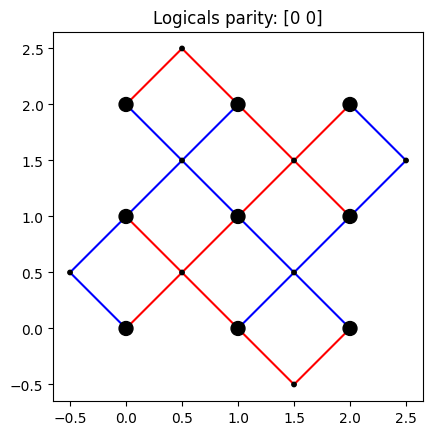

In [3]:
code = surface_code(CODE_DISTANCE)
parity_info = code.deformation_parity_info(jnp.zeros(CODE_DISTANCE**2, dtype=jnp.int32))
code.show(parity_info)

# Replay buffer

In [4]:
replay_buffer = UniformReplayBuffer(
    buffer_size=BUFFER_SIZE,
    batch_size=BATCH_SIZE,
    num_qubits=CODE_DISTANCE**2
)
buffer_state = replay_buffer.empty_buffer()

# Agent

In [5]:
dm = DeformationManager(jnp.arange(6), CODE_DISTANCE)

class AgentModel(CNNPure):

    def __init__(self, input_shape, conv_layers):
        super().__init__(input_shape, conv_layers)

    def apply(
        self,
        params: list[tuple[jnp.ndarray, jnp.ndarray]],
        x: jnp.ndarray,
    ) -> jnp.ndarray:
        """Applies the CNN to a batch of input x."""
        return super().apply(
            params,
            dm.deformation_image(x)
        )

agent_model = AgentModel(
    input_shape=(6, CODE_DISTANCE, CODE_DISTANCE),
    conv_layers=AGENT_CONV_LAYERS
)

agent = DQN(
    model=agent_model,
    discount=DISCOUNT_FACTOR,
    n_actions=6*CODE_DISTANCE*CODE_DISTANCE
)

# Epsilon scaling
def inverse_scaling_decay(epsilon_start, epsilon_end, current_step, decay_rate):
    return epsilon_end + (epsilon_start - epsilon_end) / (1 + decay_rate * current_step)

# Environment

In [6]:
if environment == "CNN":
    decoder_model = CNNDual(
        input_shape_primary=(1, CODE_DISTANCE+1, CODE_DISTANCE+1), 
        input_shape_secondary=(DEFORMATION_OPTIONS.shape[0], CODE_DISTANCE, CODE_DISTANCE), 
        conv_layers=DECODER_CONV_LAYERS, 
        fc_layers=DECODER_FC_LAYERS
    )

    env = Environment(
        model=decoder_model,
        model_params=decoder_params,
        noise_model=ERROR_PROBS,
        code=code,
        shots=ESTIMATION_SHOTS
    )
elif environment == "PML":
    env = Environment(
        noise_model=ERROR_PROBS,
        code=code,
    )

# Optimizer

In [7]:
learning_rate = optax.exponential_decay(
    init_value = LEARNAING_RATE,
    transition_steps = TRANSITION_STEP,
    decay_rate = DECAY_RATE,
)
optimizer = optax.adam(learning_rate)

# Train the RL-agent

In [21]:
def train(
    timesteps: int,
    random_seed: int,
    target_net_update_freq: int,
    environment_reset_freq: int,
    model: CNNPure,
    optimizer: optax.GradientTransformation,
    buffer_state: dict,
    buffer_size: int,
    agent: DQN,
    env: Environment,
    replay_buffer: UniformReplayBuffer,
    epsilon_decay_fn,
    epsilon_start: float,
    epsilon_end: float,
    decay_rate: float,
):
    """
    Train the RL-agent to find the best deformation of the given size surface code
    """

    def _fori_body(
        i: int,
        val: tuple
    ):
        (
            online_net_params,
            target_net_params,
            deformation,
            deformations,
            score,
            scores,
            rewards,
            disallowed_actions,
            opt_state,
            buffer_state,
            act_key,
            env_key,
            sample_key,
            losses,
        ) = val
        
        # Let agent pick a deformation action
        action, done, act_key = agent.act(
            act_key,
            online_net_params,
            deformation,
            disallowed_actions,
            epsilon = epsilon_decay_fn(epsilon_start, epsilon_end, i, decay_rate),
        )

        # Update the deformation
        new_deformation = env.update_state(
            action,
            deformation
        )

        # Calculate the agents reward
        reward, new_score, env_key = env.reward(
            env_key,
            score,
            new_deformation,
        )

        # Add the current experience to the buffer
        experience = (deformation, score, action, reward, new_deformation, done)
        buffer_state = replay_buffer.add(
            buffer_state,
            experience,
            idx=i
        )

        # Update the agent
        experiences, sample_key = replay_buffer.sample(
            sample_key,
            buffer_state,
            jnp.min(jnp.array([i, buffer_size]))
        )
        online_net_params, opt_state, loss = agent.update(
            online_net_params,
            target_net_params,
            optimizer,
            opt_state,
            experiences,
        )

        # update the target parameters every ``target_net_update_freq`` steps
        target_net_params = lax.cond(
            i % target_net_update_freq == 0,
            lambda _: online_net_params,
            lambda _: target_net_params,
            operand=None,
        )

        # Periodic reset of the environment
        # new_deformation, new_score, env_key = lax.cond(
        #     i % environment_reset_freq == 0,
        #     lambda key: env.reset(key),
        #     lambda key: (new_deformation, new_score, key),
        #     operand=env_key,
        # )

        (
            disallowed_actions,
            new_deformation,
            new_score,
        ) = lax.cond(
            new_score > score,
            lambda _: (
                    jnp.zeros_like(disallowed_actions)
                        # Do not allow actions that will leave the deformation unchanged
                        .at[env.num_qubits*new_deformation + jnp.arange(env.num_qubits)].set(True)
                        # Do not allow the action that will go back to the just seen state
                        .at[env.num_qubits*deformation[action%env.num_qubits] + (action%env.num_qubits)].set(True),
                    new_deformation,
                    new_score,
                ),
            lambda _: (
                    # Do not allow the action that was just taken as that did not yield a better deformation
                    disallowed_actions.at[action].set(True),
                    deformation,
                    score,
                ),
            operand=disallowed_actions,
        )
        

        # Update tracked information
        rewards = rewards.at[i].set(reward)
        losses = losses.at[i].set(loss)
        deformations = deformations.at[i].set(new_deformation)
        scores = scores.at[i].set(new_score)

        return (
            online_net_params,
            target_net_params,
            new_deformation,
            deformations,
            score,
            scores,
            rewards,
            disallowed_actions,
            opt_state,
            buffer_state,
            act_key,
            env_key,
            sample_key,
            losses,
        )
    
    act_key, sample_key, env_key, init_online_key, init_target_key = random.split(
        random.key(random_seed), num=5
    )

    target_net_params = model.init(init_target_key)
    online_net_params = model.init(init_online_key)

    deformation, score, env_key = env.reset(env_key)

    opt_state = optimizer.init(online_net_params)

    losses = jnp.empty(timesteps, dtype=jnp.float32)
    rewards = jnp.empty(timesteps, dtype=jnp.float32)
    scores = jnp.empty(timesteps, dtype=jnp.float32)
    deformations = jnp.empty((timesteps, env.num_qubits), dtype=jnp.int32)
    disallowed_actions = jnp.zeros(agent.n_actions, dtype=jnp.bool)

    val_init = (
        online_net_params,
        target_net_params,
        deformation,
        deformations,
        score,
        scores,
        rewards,
        disallowed_actions,
        opt_state,
        buffer_state,
        act_key,
        env_key,
        sample_key,
        losses,
    )

    vals = lax.fori_loop(0, TRAINING_BATCHES, _fori_body, val_init)

    return vals

In [22]:
(
    online_net_params,
    target_net_params,
    deformation,
    deformations,
    score,
    scores,
    rewards,
    disallowed_actions,
    opt_state,
    buffer_state,
    act_key,
    env_key,
    sample_key,
    losses,
) = train(
    timesteps = TRAINING_BATCHES,
    random_seed = SEED,
    target_net_update_freq = 10,
    environment_reset_freq = CODE_DISTANCE**2*3,
    model = agent_model,
    optimizer = optimizer,
    buffer_state = buffer_state,
    buffer_size = BUFFER_SIZE,
    agent = agent,
    env = env,
    replay_buffer = replay_buffer,
    epsilon_decay_fn = inverse_scaling_decay,
    epsilon_start = 0.5,
    epsilon_end = 0,
    decay_rate = 1E-3,
)

Input image of size 3 by 3 with 6 channels
to image of size 3 by 3 with 4 channels
to image of size 3 by 3 with 3 channels
to image of size 3 by 3 with 4 channels
to image of size 3 by 3 with 6 channels
Input image of size 3 by 3 with 6 channels
to image of size 3 by 3 with 4 channels
to image of size 3 by 3 with 3 channels
to image of size 3 by 3 with 4 channels
to image of size 3 by 3 with 6 channels


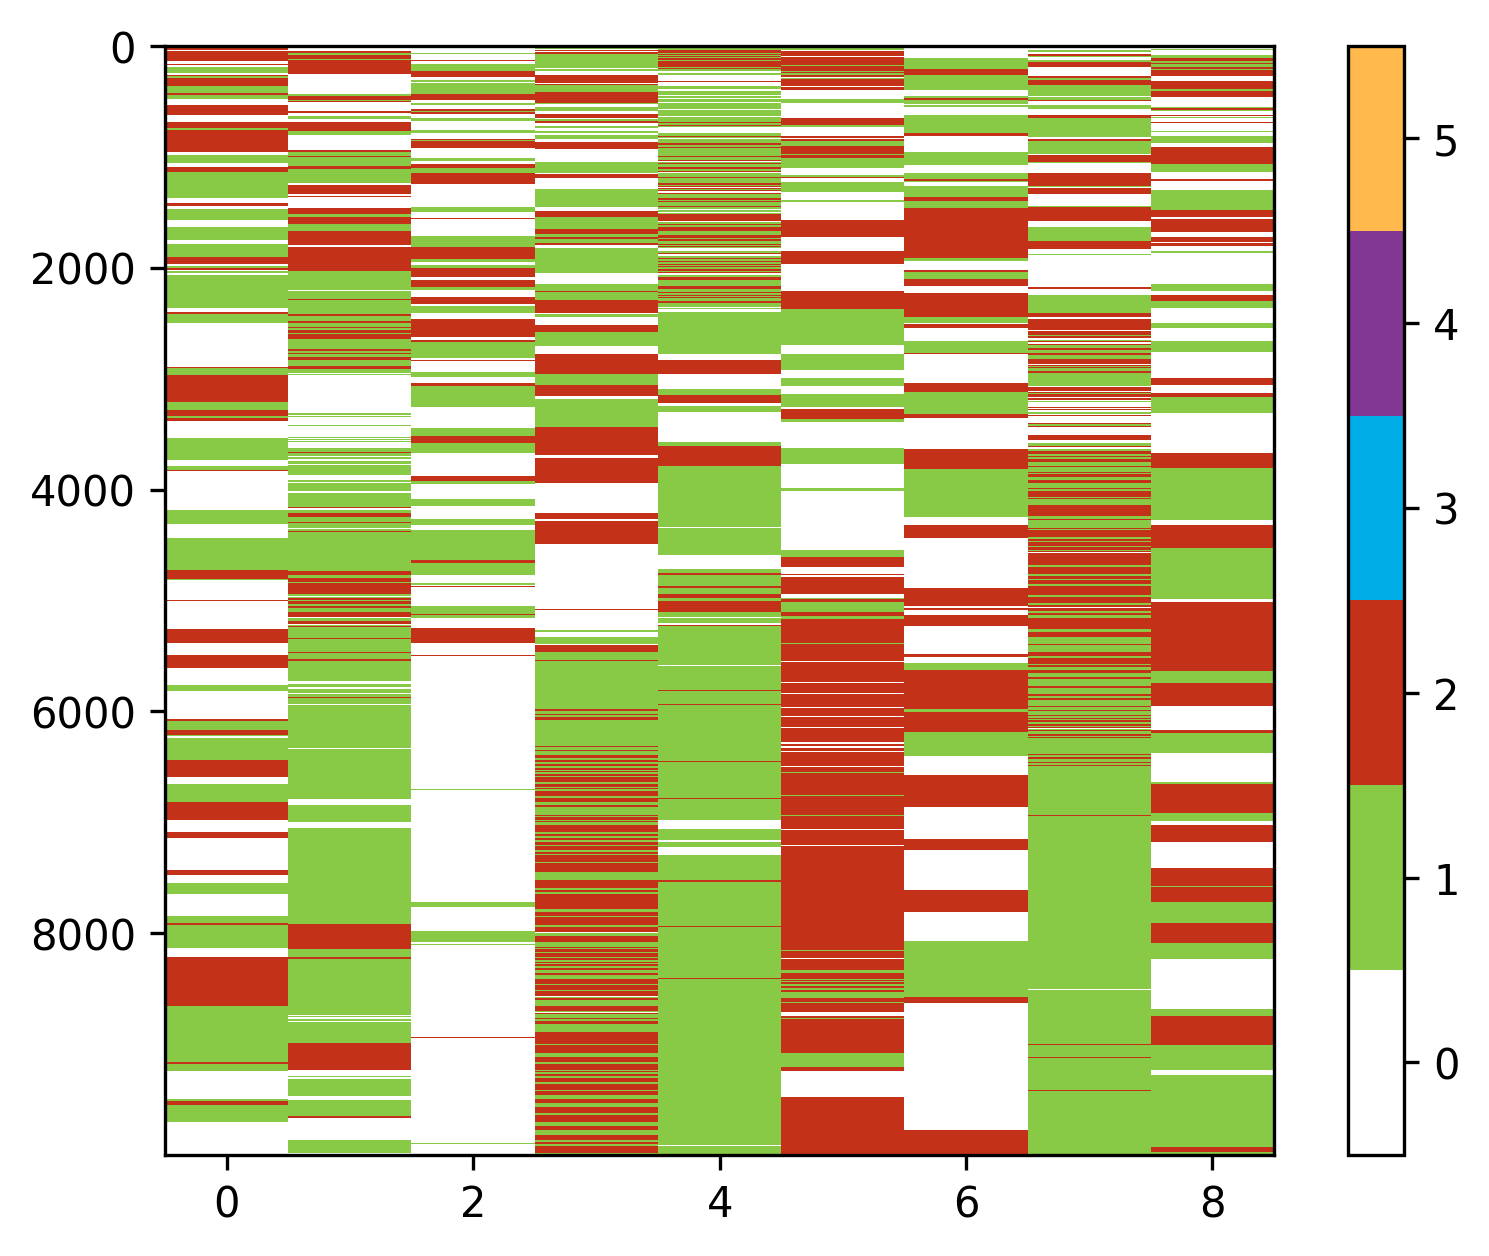

In [23]:
from matplotlib.colors import ListedColormap
deformation_cmap = ListedColormap([
    "#FFFFFF", # I
    "#88C946", # X-Y
    "#C43119", # Y-Z
    "#00ADE7", # X-Z
    "#833794", # X-Y-Z
    "#FFB94C", # X-Z-Y
])

plt.figure(dpi=300)
plt.imshow(jnp.array([0,0,1,2,2,1])[deformations], aspect=CODE_DISTANCE**2/TRAINING_BATCHES, interpolation="nearest", cmap=deformation_cmap, vmin=-.5, vmax=5.5)
plt.colorbar()
plt.show()

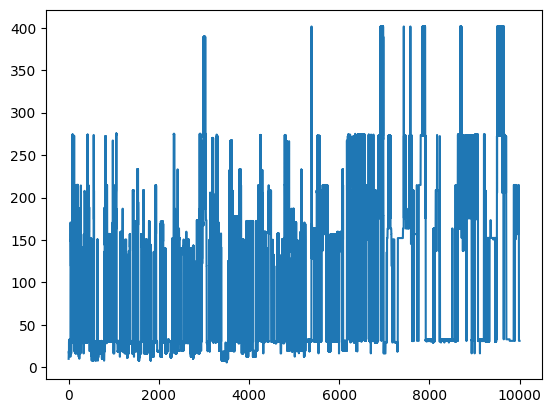

In [24]:
plt.figure()
plt.plot(scores)
plt.show()

In [11]:
# key = random.key(23)

In [12]:
# deformation = random.randint(key, shape=9, minval=0, maxval=6)
# img = dm.deformation_image(deformation)

# subkey, key = random.split(key)
# actions = jnp.where(img.flatten() == 1)[0]
# action = actions[random.randint(subkey, shape=(1), minval=0, maxval=actions.shape[0]-1)]

# for d, i in zip(*jnp.unravel_index(
#     actions,
#     shape=(
#         6,
#         CODE_DISTANCE**2,
#     )
# )):
#     print(deformation[i], d, deformation[i] == d)

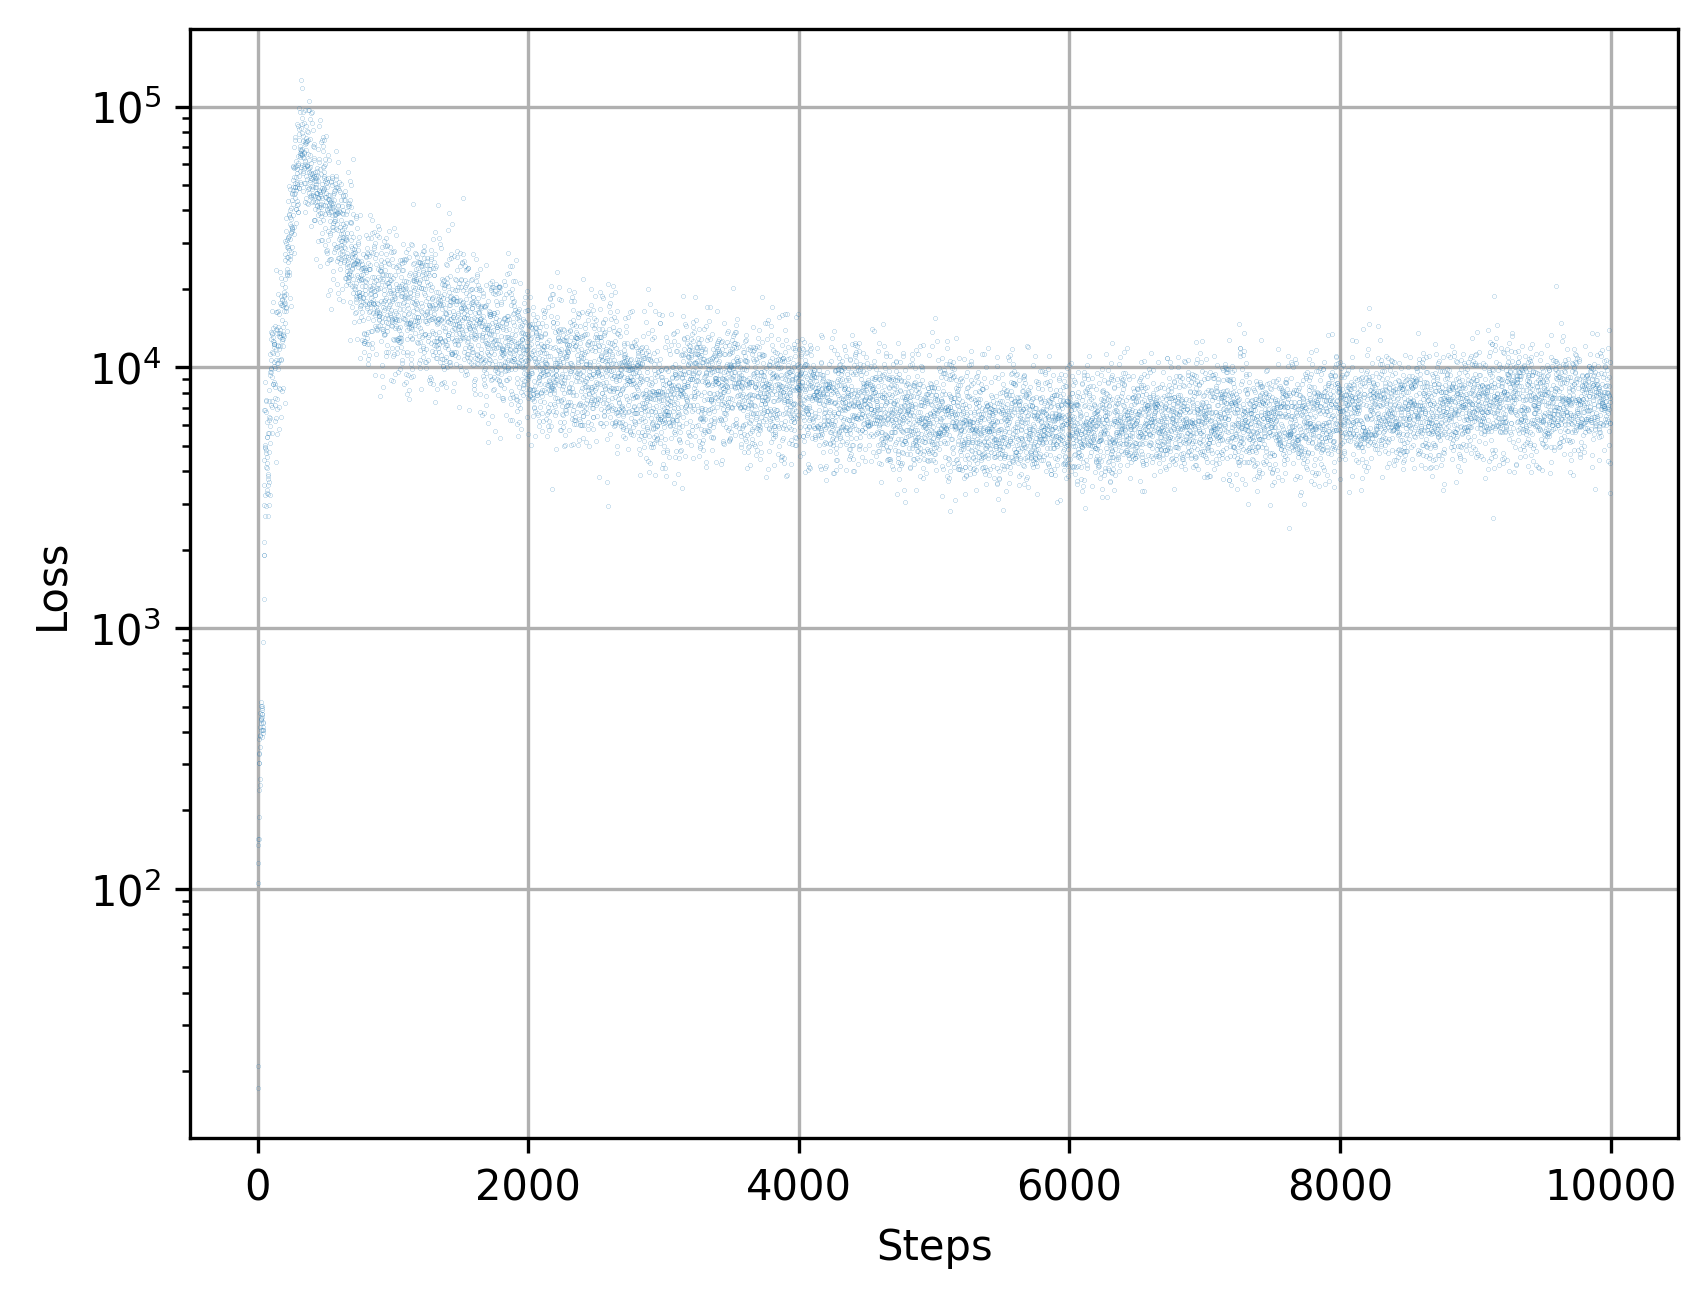

In [19]:
end = losses.shape[0]
plt.figure(dpi=300)
plt.plot(jnp.arange(end), losses, '.', lw=.5, ms=.1)
plt.grid()
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.yscale('log')
# plt.xlim(50000, 51000)
plt.show()

In [14]:
deformation = jnp.zeros(CODE_DISTANCE**2, dtype=jnp.int32)
key = random.key(42)

for _ in range(10):
    action, done, key = agent.act(
        key,
        online_net_params,
        deformation,
        disallowed_actions = jnp.zeros(agent.n_actions).at[CODE_DISTANCE**2*deformation + jnp.arange(CODE_DISTANCE**2)].set(True),
        epsilon=0
    )
    d_idx, q_idx = jnp.unravel_index(action, (6,CODE_DISTANCE*CODE_DISTANCE))
    print(deformation, "->", action, "=", f"deformation {d_idx} on data qubit {q_idx}")
    deformation = deformation.at[q_idx].set(d_idx)

[0 0 0 0 0 0 0 0 0] -> 35 = deformation 3 on data qubit 8
[0 0 0 0 0 0 0 0 3] -> 32 = deformation 3 on data qubit 5
[0 0 0 0 0 3 0 0 3] -> 49 = deformation 5 on data qubit 4
[0 0 0 0 5 3 0 0 3] -> 40 = deformation 4 on data qubit 4
[0 0 0 0 4 3 0 0 3] -> 46 = deformation 5 on data qubit 1
[0 5 0 0 4 3 0 0 3] -> 49 = deformation 5 on data qubit 4
[0 5 0 0 5 3 0 0 3] -> 40 = deformation 4 on data qubit 4
[0 5 0 0 4 3 0 0 3] -> 49 = deformation 5 on data qubit 4
[0 5 0 0 5 3 0 0 3] -> 40 = deformation 4 on data qubit 4
[0 5 0 0 4 3 0 0 3] -> 49 = deformation 5 on data qubit 4
